[# Jump To Model Implementation](#How-the-model-can-be-used?)

Data: https://www.kaggle.com/datasets/susant4learning/holiday-package-purchase-prediction

Stakeholder: **Trav#loka, Tik#t.com** or other travel company startup

Anyway, the problem can be as straightforward as predicting if a consumer will take the product or not, or we can make it a little bit more complex, as "will the consumer take the product, **after** a marketing pitch?". So it's basically a bayesian probability. Not only P(take product) but P(take product | marketing pitch).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.metrics import ConfusionMatrixDisplay

style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('Travel.csv')
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [3]:
# To check the independence of rows
df.duplicated(subset='CustomerID').any()

False

In [4]:
# We don't want to predict P(take prod), but P(take prod | company invited), because this is where the ineffective marketing cost come from
df_mkt = df[df['TypeofContact'] == 'Company Invited']

# Drop some looking-forward leakage
X = df_mkt.drop(['CustomerID','ProdTaken', 'TypeofContact', 'PitchSatisfactionScore', 'ProductPitched', 'DurationOfPitch'], axis = 1)
y = df_mkt['ProdTaken']

In [5]:
df_mkt.isna().sum().to_frame().T

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,0,0,57,0,0,85,0,0,0,15,0,4,0,38,0,0,0,9,0,70


In [6]:
df_mkt.shape

(1419, 20)

My plan is to predict whether a consumer will take the product or no if we gave them a marketing pitch, and then try to decrease ineffective marketing pitch & cost.
* Effective marketing pitch -> TypeofContact = "Company Invited",  and consumer take the product
* Ineffective marketing pitch -> TypeofContact = "Company Invited", and have a long "DurationofPitch" but the consumer don't take the product nonetheless.

For simplicity, I will only use Logistic Regression and Random Forest.

# Some general exploration

Because some of the variables are interesting to explore.

In [7]:
# Create categorical df ProdTaken for easier interpretation
df['ProdTaken_YN'] = df['ProdTaken'].apply(lambda x: 'Yes' if x == 1 else 'No')

**Type of contact**

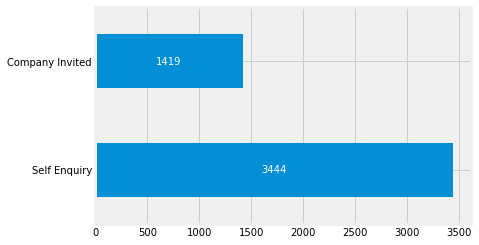

In [8]:
g = df['TypeofContact'].value_counts().plot(kind='barh')

for p in g.patches:
    g.annotate(format(p.get_width(), '0'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

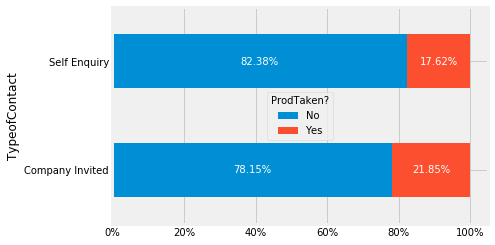

In [9]:
g = df.groupby('TypeofContact')['ProdTaken_YN'].value_counts(normalize=True).unstack('ProdTaken_YN').plot(kind='barh', stacked=True)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.set_ylabel('TypeofContact')
g.legend(loc='center', title = "ProdTaken?")

for p in g.patches:
    g.annotate(format(p.get_width(), '.2%'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

Okay. So, only 21.85% individual that's invited by the company actually taken the offer.

**Duration of Pitch**

In [10]:
df['DurationOfPitch'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
DurationOfPitch,4637.0,15.490835,8.519643,5.0,9.0,13.0,20.0,127.0


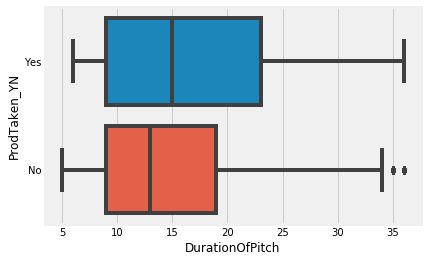

In [11]:
sns.boxplot(data = df[df['DurationOfPitch'] < 60], x = 'DurationOfPitch', y = 'ProdTaken_YN')

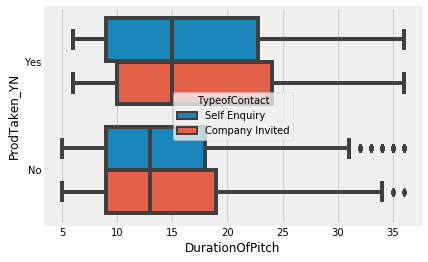

In [12]:
sns.boxplot(data = df[df['DurationOfPitch'] < 60], x = 'DurationOfPitch', y = 'ProdTaken_YN', hue = 'TypeofContact')

Maybe short duration of pitch means that the consumer isn't really interested with the product offered. But it's a weak assumption because 75% of people, either they take or not the product, have duration of pitch < 20 minutes. But, the longer the duration of pitch, the higher the marketing cost, right?

**Number Of Followup**

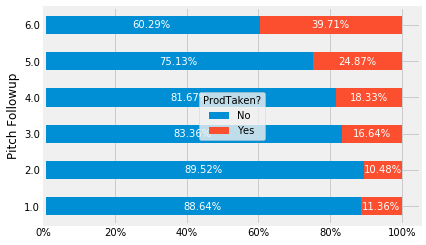

In [13]:
g = df.groupby('NumberOfFollowups')['ProdTaken_YN'].value_counts(normalize=True).unstack('ProdTaken_YN').plot(kind='barh', stacked=True)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.set_ylabel('Pitch Followup')
g.legend(loc='center', title = "ProdTaken?")

for p in g.patches:
    g.annotate(format(p.get_width(), '.2%'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

Higher followups -> Higher chance the customer will take the product!

**Pitch Satisfaction Score**

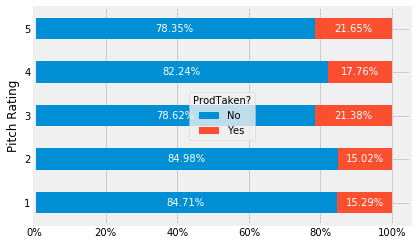

In [14]:
g = df.groupby('PitchSatisfactionScore')['ProdTaken_YN'].value_counts(normalize=True).unstack('ProdTaken_YN').plot(kind='barh', stacked=True)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
g.set_ylabel('Pitch Rating')
g.legend(loc='center', title = "ProdTaken?")

for p in g.patches:
    g.annotate(format(p.get_width(), '.2%'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

Text(0, 0.5, 'Pitch Rating')

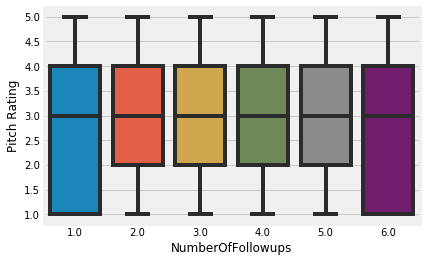

In [15]:
g = sns.boxplot(data = df, y = 'PitchSatisfactionScore', x = 'NumberOfFollowups')
g.set_ylabel('Pitch Rating')

Not much things we can do. We'll start to model.

# Feature Selection

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

cat_cols = X_train.select_dtypes(include = 'object').copy().columns
num_cols = X_train.select_dtypes(include = 'number').copy().columns

X_train.shape

(1135, 14)

Okay, we have a really small dataset, so, it's better for our features also be minimal. It's important especially when we're selecting our categorical features, because maybe we wanted to one hot encode it later. 1135 independent rows, I think 10 features is already high.

In [17]:
cat_cols

Index(['Occupation', 'Gender', 'MaritalStatus', 'Designation'], dtype='object')

In [18]:
num_cols

Index(['Age', 'CityTier', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome'],
      dtype='object')

In [19]:
X_train[cat_cols].nunique().sort_values().to_frame().T

,Occupation,Gender,MaritalStatus,Designation
0,3,3,4,5


In [20]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in cat_cols:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
# chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result.merge(X_train[cat_cols].describe().T.reset_index(), left_on ='Feature', right_on = 'index').sort_values(by = ['p-value', 'unique'])

,Feature,p-value,index,count,unique,top,freq
2,MaritalStatus,0.000000,MaritalStatus,1135,4,Married,552
3,Designation,0.000000,Designation,1135,5,Manager,426
0,Occupation,0.000001,Occupation,1135,3,Salaried,572
1,Gender,0.488033,Gender,1135,3,Male,688


In [21]:
selected_cat_cols = ['MaritalStatus', 'Designation', 'Occupation']

In [22]:
X_train[num_cols].nunique().sort_values().to_frame().T

,Passport,OwnCar,CityTier,PreferredPropertyStar,NumberOfPersonVisiting,NumberOfChildrenVisiting,NumberOfFollowups,NumberOfTrips,Age,MonthlyIncome
0,2,2,3,3,4,4,6,11,44,734


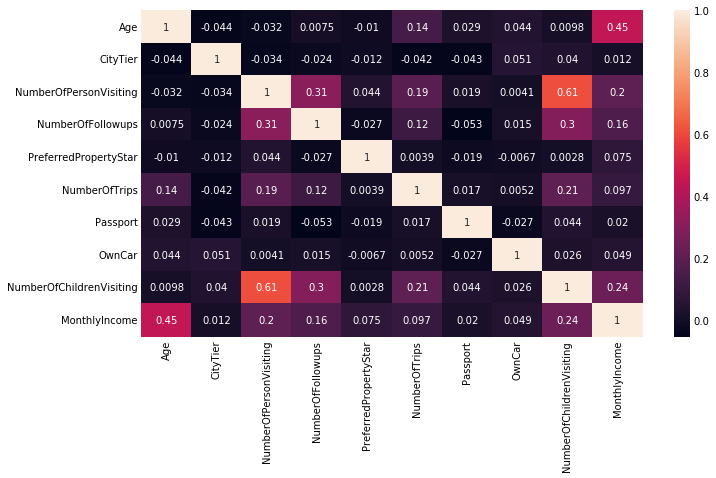

In [23]:
fig = plt.figure(figsize = (10,6))
sns.heatmap(X_train[num_cols].corr(), annot=True)

In [24]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train[num_cols].fillna(X_train[num_cols].median()), y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': num_cols, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.merge(X_train[num_cols].describe().T.reset_index(), left_on = 'Numerical_Feature', right_on = 'index').sort_values(['F-Score', 'count'], ascending=False)

,Numerical_Feature,F-Score,p values,index,count,mean,std,min,25%,50%,75%,max
6,Passport,93.165921,0.000000e+00,Passport,1135.0,0.288106,0.453080,0.0,0.0,0.0,1.00,1.0
0,Age,31.590926,2.390000e-08,Age,1085.0,37.173272,8.794257,18.0,31.0,36.0,43.00,61.0
9,MonthlyIncome,27.499026,1.874000e-07,MonthlyIncome,1082.0,23282.390943,4899.010680,16051.0,20135.0,22239.5,25214.25,38651.0
4,PreferredPropertyStar,9.736779,1.851823e-03,PreferredPropertyStar,1131.0,3.528736,0.771056,3.0,3.0,3.0,4.00,5.0
3,NumberOfFollowups,5.619424,1.792911e-02,NumberOfFollowups,1123.0,3.735530,1.003760,1.0,3.0,4.0,4.00,6.0
1,CityTier,5.600917,1.811850e-02,CityTier,1135.0,1.667841,0.923806,1.0,1.0,1.0,3.00,3.0
2,NumberOfPersonVisiting,2.756483,9.713769e-02,NumberOfPersonVisiting,1135.0,2.895154,0.736144,1.0,2.0,3.0,3.00,4.0
5,NumberOfTrips,1.254993,2.628383e-01,NumberOfTrips,1103.0,3.205802,1.977249,1.0,2.0,3.0,4.00,22.0
7,OwnCar,0.454163,5.005022e-01,OwnCar,1135.0,0.610573,0.487835,0.0,0.0,1.0,1.00,1.0
8,NumberOfChildrenVisiting,0.009493,9.224012e-01,NumberOfChildrenVisiting,1129.0,1.173605,0.867035,0.0,1.0,1.0,2.00,3.0


The score makes me wonder if the pitching simply failed because the target don't have a passport.............

Anyway, from the cardinality of our categorical feature, we already obtained 9 columns, and the lowest P-value for our categorical feature is 0.000001 or 1e-6. So I think we can only pick the top 3 numerical values (Passport, Age, MonthlyIncome)

In [25]:
selected_num_cols = ['Passport', 'Age', 'MonthlyIncome']
selected_cols = selected_cat_cols + selected_num_cols

# Feature Engineering

In [26]:
X_train[selected_cols].isna().sum()

MaritalStatus     0
Designation       0
Occupation        0
Passport          0
Age              50
MonthlyIncome    53
dtype: int64

In [27]:
X_test[selected_cols].isna().sum()

MaritalStatus     0
Designation       0
Occupation        0
Passport          0
Age               7
MonthlyIncome    17
dtype: int64

In [28]:
from sklearn.impute import SimpleImputer

numimputer = SimpleImputer(strategy = 'median')

X_train[selected_num_cols] = numimputer.fit_transform(X_train[selected_num_cols])
X_test[selected_num_cols] = numimputer.transform(X_test[selected_num_cols])

In [29]:
pd.get_dummies(X_train[selected_cat_cols], prefix_sep = ':')

,MaritalStatus:Divorced,MaritalStatus:Married,MaritalStatus:Single,MaritalStatus:Unmarried,Designation:AVP,Designation:Executive,Designation:Manager,Designation:Senior Manager,Designation:VP,Occupation:Large Business,Occupation:Salaried,Occupation:Small Business
3957,0,0,0,1,0,0,0,1,0,0,1,0
1781,0,1,0,0,0,0,0,1,0,0,1,0
3797,0,1,0,0,0,1,0,0,0,1,0,0
4058,0,1,0,0,0,0,1,0,0,0,0,1
3261,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,0,0,1,0,0,0,1,0,0,0,1
4624,0,0,1,0,1,0,0,0,0,0,1,0
3745,0,1,0,0,1,0,0,0,0,0,0,1
1057,0,0,1,0,0,0,1,0,0,1,0,0


In [30]:
X_trainf = pd.concat([X_train[selected_num_cols], pd.get_dummies(X_train[selected_cat_cols], prefix_sep = ':')], axis = 1)
X_testf = pd.concat([X_test[selected_num_cols], pd.get_dummies(X_test[selected_cat_cols], prefix_sep = ':')], axis = 1)

In [31]:
def data_processing(df):
    dfx = df.copy()
    dfx[selected_num_cols] = numimputer.transform(dfx[selected_num_cols])
    num = dfx[selected_num_cols]
    cat = pd.get_dummies(dfx[selected_cat_cols], prefix_sep = ':')
    return pd.concat([num, cat], axis = 1)

# Modelling

First, we will check the current performance of our marketing. So much inefficiencies right?

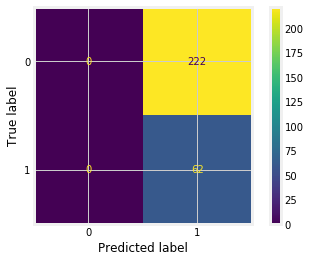

In [32]:
currentperform = y_test.to_frame()
currentperform['predict'] = 1
ConfusionMatrixDisplay.from_predictions(currentperform['ProdTaken'], currentperform['predict'])

Objective:
* TP > FP because False positive -> Ineffective marketing
* TP > FN because False negative -> So much opportunity wasted!

Ah yeah, because our dataset is kinda low. So, it's only about 75 independent events per 1 feature

In [33]:
X_trainf.shape[0] / X_trainf.shape[1]

75.66666666666667

In [34]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(reg, X_trainf, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)

# print the mean AUROC score
print('Mean AUROC: %.4f' % (AUROC))

Mean AUROC: 0.7297


In [35]:
reg.fit(X_trainf, y_train)
print('success')

success


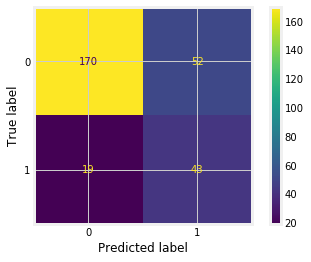

In [36]:
y_hat_test = reg.predict(X_testf)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test)

High false positive? Hmm. It means that with logistic regression the marketing is still a little bit ineffective. Let's try using **tree based algorithm**.

In [37]:
rf = RandomForestClassifier()
rf.fit(X_trainf, y_train)
print('success')

success


In [38]:
scores = cross_val_score(rf, X_trainf, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)

# print the mean AUROC score
print('Mean AUROC: %.4f' % (AUROC))

Mean AUROC: 0.8873


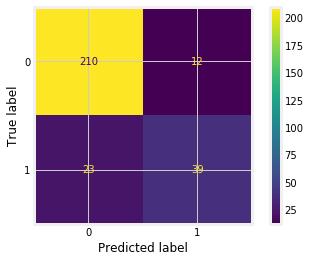

In [39]:
y_hat_test = rf.predict(X_testf)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test)

Better. But still, the false negative is kinda high, means we missed too much opportunity. 
* Maybe it's because of class imbalance. We will try use balanced weight in our algoritm.

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_trainf, y_train)

scores = cross_val_score(xgb, X_trainf, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)

# print the mean AUROC score
print('Mean AUROC: %.4f' % (AUROC))

C:\Users\Asif\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mean AUROC: 0.8727


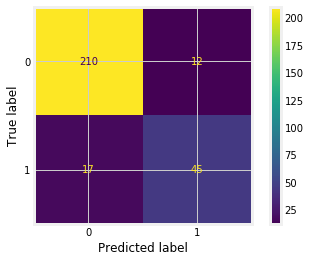

In [41]:
xgb = XGBClassifier(learning_rate = 0.34, objective = 'binary:logistic', eval_metric = 'aucpr', random_state = 42)
xgb.fit(X_trainf, y_train)
y_hat_test = xgb.predict(X_testf)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test)

In [42]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       222
           1       0.79      0.73      0.76        62

    accuracy                           0.90       284
   macro avg       0.86      0.84      0.85       284
weighted avg       0.90      0.90      0.90       284



In [43]:
# make preditions on our test set
y_hat_test = xgb.predict(X_testf)
# get the predicted probabilities
y_hat_test_proba = xgb.predict_proba(X_testf)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_testf.index

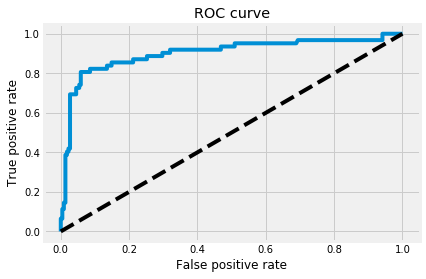

In [44]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [45]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.9013731473408892

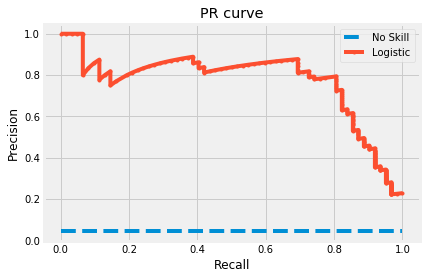

In [46]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [47]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.7697383556595908

**why after recall > 80% the performance nose dive?**

The curve smells like outlier + imbalance dataset. Let's try oversample... Not much of expectation though.

In [48]:
train_check = X_train.describe().T
train_check['IQR'] = train_check['75%'] - train_check['25%']
train_check['left_out'] = train_check['25%'] - 1.5 * train_check['IQR']
train_check['right_out'] = train_check['75%'] + 1.5 * train_check['IQR']
train_check[['mean', '50%', 'min', 'left_out', 'max', 'right_out']]

,mean,50%,min,left_out,max,right_out
Age,37.121586,36.0,18.0,14.50,61.0,58.50
CityTier,1.667841,1.0,1.0,-2.00,3.0,6.00
NumberOfPersonVisiting,2.895154,3.0,1.0,0.50,4.0,4.50
NumberOfFollowups,3.735530,4.0,1.0,1.50,6.0,5.50
PreferredPropertyStar,3.528736,3.0,3.0,1.50,5.0,5.50
NumberOfTrips,3.205802,3.0,1.0,-1.00,22.0,7.00
Passport,0.288106,0.0,0.0,-1.50,1.0,2.50
OwnCar,0.610573,1.0,0.0,-1.50,1.0,2.50
NumberOfChildrenVisiting,1.173605,1.0,0.0,-0.50,3.0,3.50
MonthlyIncome,23233.692070,22239.5,16051.0,13059.25,38651.0,32265.25


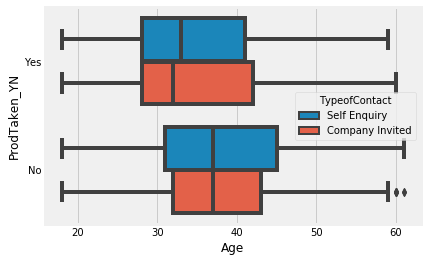

In [49]:
sns.boxplot(data = df, x = 'Age', y = 'ProdTaken_YN', hue = 'TypeofContact')

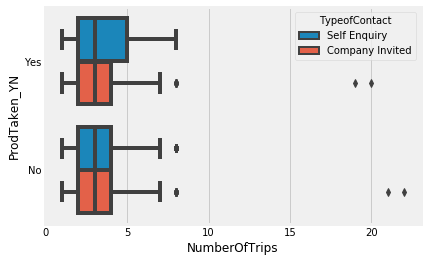

In [50]:
sns.boxplot(data = df, x = 'NumberOfTrips', y = 'ProdTaken_YN', hue = 'TypeofContact')

In [51]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_trainf, y_train)

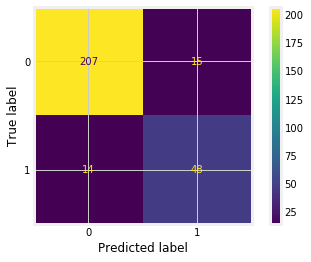

In [52]:
xgb2 = XGBClassifier(learning_rate = 0.31, objective = 'binary:logistic', eval_metric = 'aucpr', random_state = 42)
xgb2.fit(X_resampled, y_resampled)
y_hat_test2 = xgb2.predict(X_testf)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test2)

In [53]:
print(classification_report(y_test, y_hat_test2))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       222
           1       0.76      0.77      0.77        62

    accuracy                           0.90       284
   macro avg       0.85      0.85      0.85       284
weighted avg       0.90      0.90      0.90       284



In [54]:
y_hat_test_proba2 = xgb2.predict_proba(X_testf)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba2 = y_hat_test_proba2[:][: , 1]
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba2 = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba2)], axis = 1)
# Rename the columns
y_test_proba2.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba2.index = X_testf.index

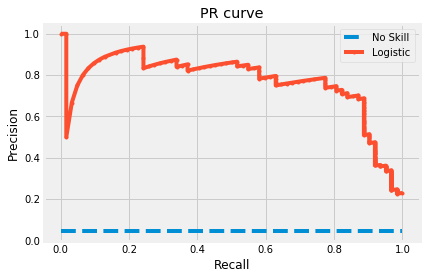

In [55]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba2['y_test_class_actual'], y_test_proba2['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

Well... A little bit better. Maybe we should try undersample? But the data is too low. So, no.

Agh, don't have anymore idea with the knowledge I have right now! Any feedback on this (how to stabilize the PR curve) will be much appreciated!

Problem:
* Recall > 0.8 will make the precision nosedive

**Threshold tuning (to maximize recall)**

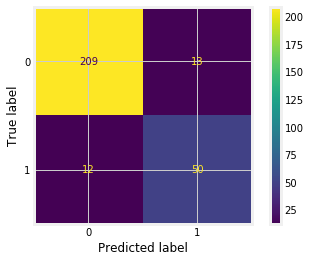

In [56]:
tr = 0.4
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_proba['y_test_class_predicted'])

In [57]:
print(classification_report(y_test, y_test_proba['y_test_class_predicted']))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       222
           1       0.79      0.81      0.80        62

    accuracy                           0.91       284
   macro avg       0.87      0.87      0.87       284
weighted avg       0.91      0.91      0.91       284



Okay, this is the best that I can do right now.

# How the model can be used?

Based on the precision recall score:
* We can slash 94% of the ineffective marketing cost
* The model can predict up to 81% of the available potential customer to be pitched, 
* Precision of 0.79 -> means that every 5 potential customer predicted, there is 1/5 chance that the one predicted actually isn't potential.

In [58]:
def last_model(df_test, model = xgb2):
    df = df_test.copy()
    return model.predict(df)

We'll see how much of last year customer that's actually potential, but because they didn't get pitched by the company, they didn't take the product.

In [59]:
# Filter self inquiry customer that didn't take the product in the end.
filter1 = df['TypeofContact'] == 'Self Enquiry'
filter2 = df['ProdTaken'] == 0
df_test = df[filter1 & filter2]
df_test.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,...,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken_YN
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,...,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0,No
6,200006,0,59.0,Self Enquiry,1,9.0,Small Business,Female,2,2.0,...,5.0,Divorced,5.0,1,2,1,1.0,Executive,17670.0,No
7,200007,0,30.0,Self Enquiry,1,30.0,Salaried,Male,3,3.0,...,3.0,Married,2.0,0,2,0,1.0,Executive,17693.0,No
9,200009,0,36.0,Self Enquiry,1,33.0,Small Business,Male,3,3.0,...,3.0,Divorced,7.0,0,3,1,0.0,Manager,20237.0,No
10,200010,0,35.0,Self Enquiry,1,22.0,Small Business,Male,2,2.0,...,4.0,Divorced,1.0,0,3,1,1.0,Executive,17426.0,No


In [60]:
df_testx = data_processing(df_test)
df_test['ProdTakenpred'] = last_model(df_test = df_testx)
df_test['ProdTaken_Pot'] = df_test['ProdTakenpred'].apply(lambda x: "Potential" if x == 1 else "Not potential")

C:\Users\Asif\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Asif\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


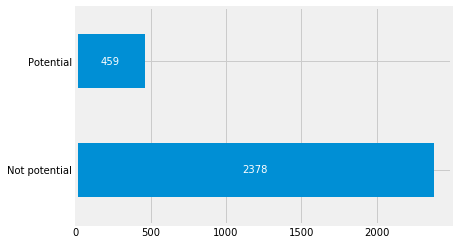

In [61]:
g = df_test.ProdTaken_Pot.value_counts().plot(kind = 'barh')

for p in g.patches:
    g.annotate(format(p.get_width(), '0'),
               xy = (p.get_x() + p.get_width() / 2,
                     p.get_y() + p.get_height() / 2,),
               ha = 'center',
               va = 'center',
               color = 'white'
              )

Based on the plot, we actually have 459 potential customer that is predicted will take the product if pitched by our company.